#Basic Autoencoder Without Rejecting

##Import libraries and get data

In [0]:
%%capture
#Install skorch package 
!pip install skorch

In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Machine learning
import torch 
from torch import nn, optim
import torch.nn.functional as F

#Dataset 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#Sklearn tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Import model related libraries
import skorch
from skorch.dataset import Dataset
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LRScheduler
from skorch.helper import predefined_split

#Vizualization 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

#Utilities
import os

## Download Data

In [0]:
#Set Kaggle API file and donwload data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
if not os.path.isfile('creditcard.csv'):
    !kaggle datasets download -d mlg-ulb/creditcardfraud
    !7z x creditcardfraud.zip

##Parse Fraud Data

In [0]:
df = pd.read_csv('creditcard.csv')
labels = df['Class']
df = df.drop(['Time','Class','Amount'], axis = 1)
cols = df.columns

In [183]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
df.columns = cols

print(df.shape)
df.head()

(284807, 28)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490


In [184]:
X_train_all, X_test, y_train_all, y_test = train_test_split(df, labels, test_size=0.1, shuffle = True, stratify = labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size=0.2, shuffle = True, stratify = y_train_all)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(205060, 28)
(51266, 28)
(28481, 28)


In [0]:
#Create Tensors
train_data_ae_t = torch.FloatTensor(X_train.to_numpy())
valid_data_ae_t = torch.FloatTensor(X_valid.to_numpy())
test_data_ae_t = torch.FloatTensor(X_test.to_numpy())

In [0]:
#Define Skorch DataSets for Training and Validation
train_data_ae = Dataset(train_data_ae_t, train_data_ae_t)
valid_data_ae = Dataset(valid_data_ae_t, valid_data_ae_t)

##Define Module Architecture

Encoder and Decoder separatly just in case.

In [0]:
class Encoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(NF, round(lat_r[0]*NF))
        self.fc2 = nn.Linear(round(lat_r[0]*NF), round(lat_r[1]*NF))
        self.fc3 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(self.fc3(x)) #Only droput on last layer no ReLu
        return x

class Decoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(round(lat_r[2]*NF), round(lat_r[1]*NF))
        self.fc2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[0]*NF))
        self.fc3 = nn.Linear(round(lat_r[0]*NF), NF)
        self.dropout = nn.Dropout(p=dropout)       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [0]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()

        self.encoder = Encoder(no_features, lat_r, dropout)
        self.decoder = Decoder(no_features, lat_r, dropout)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

##Check GPU aviability

In [189]:
# check if CUDA is available
gpu = torch.cuda.is_available()
if not gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


##Set parameters and define model

In [0]:
#Parameters setting
max_epochs = 10
dropout = 0.2
batch_size = 256
start_lr = 0.005 #Starting learning rate 
no_features = len(cols)

#Learning Rate scheduler
patience = 3 #After how many epochs with no improvemnt change LR
factor = 0.8 #Scale factor of LR 

#Encoding
latent_ratio = [0.7, 0.5, 0.3] #Must be 3 elements

In [191]:
#Create callbacks
model_path = 'skorch_ae_model.pt'
checkpoint = Checkpoint(f_params=model_path, monitor='valid_loss_best')
scheduler = LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor = factor, patience = patience, threshold=1e-3) 

net = NeuralNetRegressor(
    SimpleAutoEncoder,
    module__no_features = no_features,
    module__lat_r = latent_ratio,
    module__dropout = dropout,
    batch_size = batch_size,
    lr=start_lr,
    optimizer = optim.Adam,
    max_epochs=max_epochs,
    train_split=predefined_split(valid_data_ae),
    device='cuda' if gpu else 'cpu',
    callbacks=[checkpoint, scheduler],
    verbose = 1
)
#Default criterion is <class 'torch.nn.modules.loss.MSELoss'>

print(net)

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.SimpleAutoEncoder'>,
  module__dropout=0.2,
  module__lat_r=[0.7, 0.5, 0.3],
  module__no_features=28,
)


In [192]:
#Initialize network
net.initialize()

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SimpleAutoEncoder(
    (encoder): Encoder(
      (fc1): Linear(in_features=28, out_features=20, bias=True)
      (fc2): Linear(in_features=20, out_features=14, bias=True)
      (fc3): Linear(in_features=14, out_features=8, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (decoder): Decoder(
      (fc1): Linear(in_features=8, out_features=14, bias=True)
      (fc2): Linear(in_features=14, out_features=20, bias=True)
      (fc3): Linear(in_features=20, out_features=28, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  ),
)

##Train Autoencoder

In [193]:
net.fit(train_data_ae, y=None); #output compared with input, hide output

Re-initializing module because the following parameters were re-set: dropout, lat_r, no_features.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0029        0.0018     +  6.4744
      2        0.0019        0.0018     +  6.3534
      3        0.0018        0.0018     +  6.4370
      4        0.0018        0.0018     +  6.5648
      5        0.0018        0.0018        6.4493
      6        0.0017        0.0016     +  6.2943
      7        0.0016        0.0015     +  6.4523
      8        0.0015        0.0014     +  6.4415
      9        0.0015        0.0014     +  6.3730
     10        0.0015        0.0014        6.4252


##Test model

In [0]:
#Define function calculating losses of test samples
def aeTestLosses(X_test, X_pred, y_test):
    '''
    X_test, X_pred need to be tensors!
    Return Tensor of outliers MSE and correct samples MSE.
    '''
    outliers = []
    correct = []
    all_scores = []
    loss_func = nn.MSELoss()
    for t,p,l in zip(X_test, X_pred, y_test):
        mse_loss = loss_func(t,p).item()
        all_scores.append(mse_loss)
        if l: #Outlier
            outliers.append(mse_loss)
        else: #Not outlier
            correct.append(mse_loss)     
    return all_scores, outliers , correct

#Define function for MSE vizualisation 
def mseVizualisation(outliers, inliers):
    max_val = max(outliers + inliers)

    fig, ax = plt.subplots(figsize = (20, 3))

    plt.hlines(0,0,max_val)  # Draw a horizontal line
    plt.ylim(-0.5,0.5)

    y1 = np.zeros(np.shape(inliers))
    y2 = np.zeros(np.shape(outliers))    

    plt.plot(inliers,y1,'.',ms = 10, color='blue') 
    plt.plot(outliers,y2,'x',ms = 10, color='red') 

    plt.title('Mean Square Error of Sample Reconstrution.')
    plt.xlabel('MSE')
    plt.legend(['Inliners','Outliers'])

    plt.yticks([])
    plt.show()

#Define function for calculation and visualization of ROC
def rocVizualisation(y_test, pred_scores):
    fpr, tpr, thresholds = roc_curve(y_test, all_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (8,6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC curve')
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.3f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

**Load best model from checkpoint**

In [195]:
#Load model with lowest validation accuracy
net.initialize()  # This is important!
net.load_params(model_path)

Re-initializing module because the following parameters were re-set: dropout, lat_r, no_features.
Re-initializing optimizer.


**Run prediction and evaluate** 

In [0]:
#Run prediction and change to tensor
pred = net.predict(test_data_ae_t)
pred_t = torch.FloatTensor(pred)

#Get MSE of correct test samples and outliers
all_scores, outliers, inliers = aeTestLosses(test_data_ae_t, pred_t, y_test)

Score of AE: 20.32mu


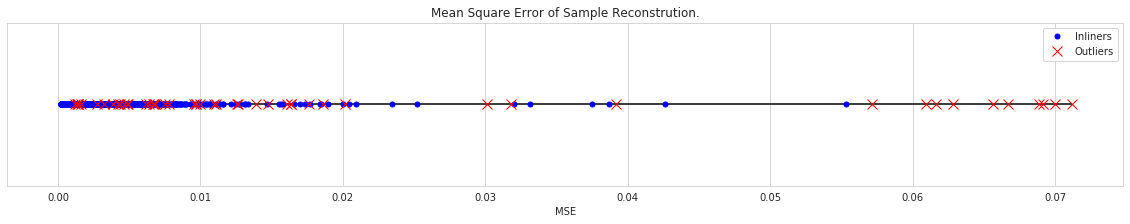

In [197]:
#Count score of autoencoder and vizualize
as_score = sum(outliers)/len(outliers) - sum(inliers)/len(inliers)
print('Score of AE: {:0.2f}mu'.format(as_score*1000))

mseVizualisation(outliers, inliers)

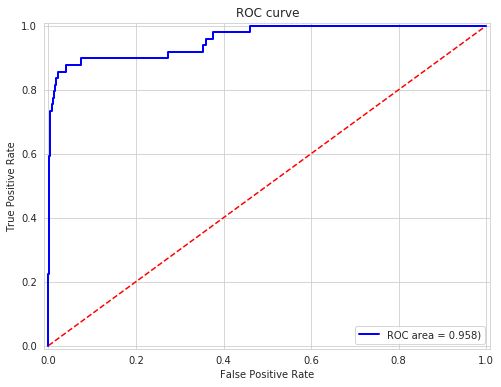

In [198]:
#Show ROC
rocVizualisation(y_test, all_scores)